In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'swamp_sparrow'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'swampsparrow-pad.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,audio,rate,spectrogram
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[0.016902675631080007, 0.01836702934042918, 0....",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,"[0.024533612567214726, 0.012936161995261142, 0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[0.0022063292319460365, 0.013836752170883053, ...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.056673408, 0.0122..."


In [9]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,NYMONT33,PAConneaut08-101,NYADIRAQBT01,NYHVVLY39,NYADIRAQSI17,PAConneaut08-091,NYHVTIV18,MIWAT21,PAGeneva08-62,MIWAT71,...,MIWAT45,PAWatsonRun08-47,PAGeneva08-02,PAConneaut08-023,PAConneaut08-093,MIWAT20,WIHOR79,NYMONT06,NYADIRAQSI10,PAConneaut08-017
0,92,172,240,158,219,157,168,104,160,125,...,152,140,95,123,87,85,117,107,74,120


### subset dataframe
- there is some noise in labelling we want to remove

In [10]:
"""fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('min')"""

"fig, axs = plt.subplots(ncols=4, figsize=(24,6))\naxs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')\naxs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')\naxs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')\naxs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('min')"

In [11]:
#plt.hist([np.sum(syllable_df.indv == i) for i in syllable_df.indv.unique()]);

In [12]:
indv_to_plot = [i for i in syllable_df.indv.unique() if np.sum(syllable_df.indv == i) > 100]
indv_to_plot

['PAConneaut08-101',
 'NYADIRAQBT01',
 'NYHVVLY39',
 'NYADIRAQSI17',
 'PAConneaut08-091',
 'NYHVTIV18',
 'MIWAT21',
 'PAGeneva08-62',
 'MIWAT71',
 'NYHVTIV26',
 'WIHOR13',
 'NYHVTIV23',
 'PAConneaut08-053',
 'NYHVTIV29',
 'PAConneaut08-030',
 'PAConneaut08-052',
 'NYMONT17',
 'NYADIRAQBT28',
 'MIWAT57',
 'NYHVTHO04',
 'PAGeneva08-45',
 'PAGeneva08-61',
 'MIWAT63',
 'WIHOR74',
 'PAConneaut08-068',
 'NYADIRAQSI16',
 'PAConneaut08-096',
 'MIWAT40',
 'WIHOR19',
 'PAWatsonRun08-34',
 'NYADIRAQBT35',
 'PAWatsonRun08-40',
 'WIHOR23',
 'NYHVVLY02',
 'PAConneaut08-062',
 'NYMONT68',
 'NYADIRAQSI27',
 'WIHOR41',
 'NYADIRAQSI23',
 'NYHVTHO27',
 'PAGeneva08-39',
 'NYMONT29',
 'WIHOR25',
 'NYHVTIV25',
 'NYADIRAQBT33',
 'NYMONT51',
 'NYHVTIV07',
 'NYHVTHO17',
 'PAWatsonRun08-02',
 'PAGeneva08-64',
 'NYADIRAQSI15',
 'MIWAT12',
 'NYHVVLY28',
 'NYHVTHO08',
 'MIWAT44',
 'PAGeneva08-27',
 'NYADIRAQBT25',
 'WIHOR12',
 'NYADIRAQSI26',
 'PAGeneva08-53',
 'NYADIRAQBT38',
 'WIHOR66',
 'PAConneaut08-014',
 'NY

In [13]:
subset_df = syllable_df[
    syllable_df.indv.isin(indv_to_plot) & 
    np.array([np.sum(i) > 0.2 for i in syllable_df.spectrogram.values])
]

In [14]:
subset_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,audio,rate,spectrogram
0,0.0935,0.0995,0.0,0.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[0.06969332862600451, 0.06959801897460591, 0.0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18450777, 0...."
1,0.1075,0.1605,0.0,1.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[0.05956509596237225, 0.06447900194559553, 0.0...",44100,"[[0.0, 0.0, 0.24632797, 0.16177763, 0.09246848..."
2,0.1770,0.2170,0.0,2.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[-0.0016472223832536582, -0.010803575765281171...",44100,"[[0.0, 0.0, 0.043056857, 0.015127991, -0.00225..."


In [15]:
subset_df[:10]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,audio,rate,spectrogram
0,0.0935,0.0995,0.0,0.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[0.06969332862600451, 0.06959801897460591, 0.0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18450777, 0...."
1,0.1075,0.1605,0.0,1.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[0.05956509596237225, 0.06447900194559553, 0.0...",44100,"[[0.0, 0.0, 0.24632797, 0.16177763, 0.09246848..."
2,0.1770,0.2170,0.0,2.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[-0.0016472223832536582, -0.010803575765281171...",44100,"[[0.0, 0.0, 0.043056857, 0.015127991, -0.00225..."
3,0.2690,0.2765,1.0,0.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[0.06307313459012304, 0.06570141840239573, 0.0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.2477134, 0.212571..."
4,0.2795,0.3395,1.0,1.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[-0.030964259441389225, -0.0263069614956131, -...",44100,"[[0.0, 0.08078519, 0.1313302, 0.2087228, 0.122..."
5,0.3530,0.3935,1.0,2.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[0.06448316695245321, 0.05989226929086981, 0.0...",44100,"[[0.0, 0.0, 0.12290526, -0.0032384768, -0.0040..."
6,0.4390,0.4455,2.0,0.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[-0.009802128277609592, -0.0013682773566090108...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009875438, 0..."
7,0.4505,0.5080,2.0,1.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[0.012309962480153463, -0.005335512931172494, ...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,0.5210,0.5600,2.0,2.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[-0.011615191475445997, 0.007360380736143804, ...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,0.5990,0.6065,3.0,0.0,PAConneaut08-101,0,PymConneaut08T101A-Z,"[0.003808433449496492, 0.011299177707758474, 0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


#### cluster and plot

In [16]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [17]:
hparams = HParams()
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.9s


[Parallel(n_jobs=-1)]: Done 1867 out of 1867 | elapsed:    5.8s finished


In [18]:
subset_df.key.values

array(['PymConneaut08T101A-Z', 'PymConneaut08T101A-Z',
       'PymConneaut08T101A-Z', ..., 'PymWatsonRun08T41C-Z',
       'PymWatsonRun08T41C-Z', 'PymWatsonRun08T41C-Z'], dtype=object)

In [19]:
population = np.array([dataset.data_files[key].data["POPID"]  if key in dataset.data_files else None for key in subset_df.key.values])
population[:3]

array(['Conneaut, PA', 'Conneaut, PA', 'Conneaut, PA'], dtype=object)

In [20]:
len(population)

91336

In [21]:
len(subset_df)

91336

In [22]:
subset_df = subset_df[np.array(population) != None]
population = population[np.array(population) != None]

In [23]:
specs = list(subset_df.spectrogram.values)
#specs = [i/np.max(i) for i in specs if np.sum(i) > 100]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(91276, 704)

In [24]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [25]:
cuml_umap = cumlUMAP(min_dist=0.25)
z = list(cuml_umap.fit_transform(specs_flattened))

In [26]:
#fit = umap.UMAP()
#z = list(fit.fit_transform(specs_flattened))

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/rp_tree.py:439: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/rp_tree.py (446)

File "../../../../../../../mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/umap/rp_tree.py", line 446:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recurs

In [27]:
z = np.vstack(z)

### variation across populations

In [28]:
len(z), len(population)

(91276, 91276)

(-15, 15)

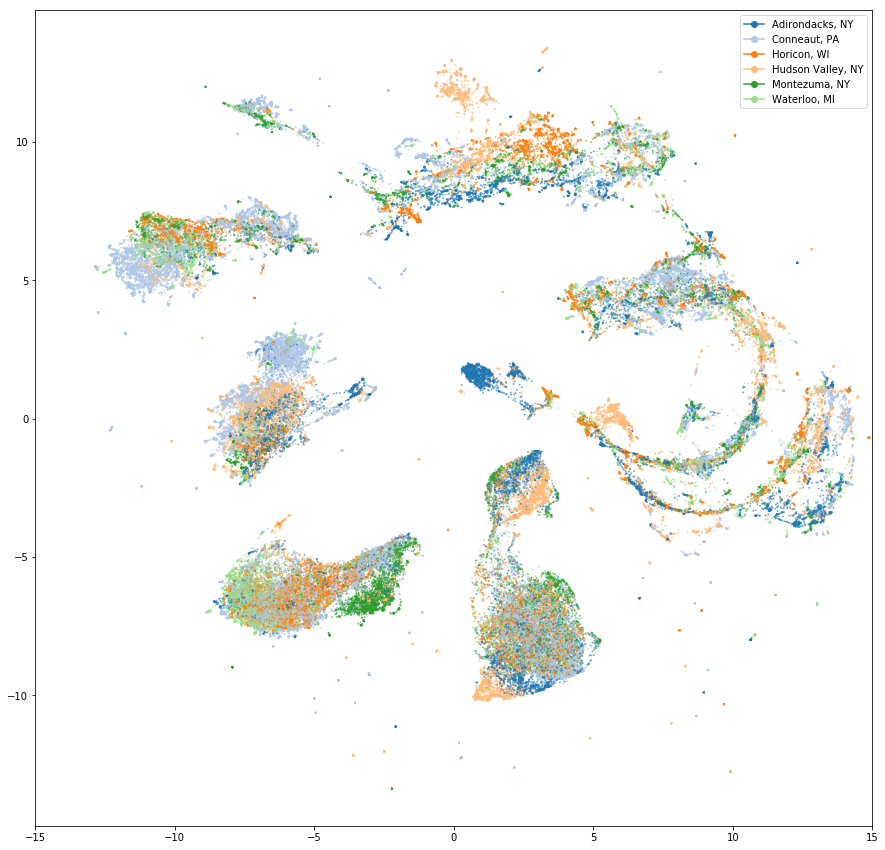

In [29]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=.5, labels = population, s=1, ax = ax)
ax.set_xlim([-15,15])

In [30]:
from avgn.visualization.projections import scatter_spec


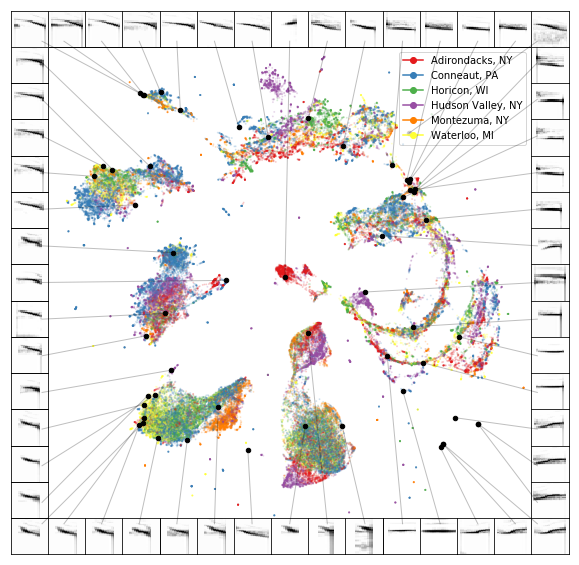

In [37]:
scatter_spec(
    np.vstack(z),
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': list(population),
        'alpha':0.15,
        's': 1,
        'show_legend': True,
        'color_palette':'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
plt.show()
#
#save_fig(FIGURE_DIR / 'swamp_sparrow_population', dpi=300, save_jpg=True)
plt.show()

In [39]:
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

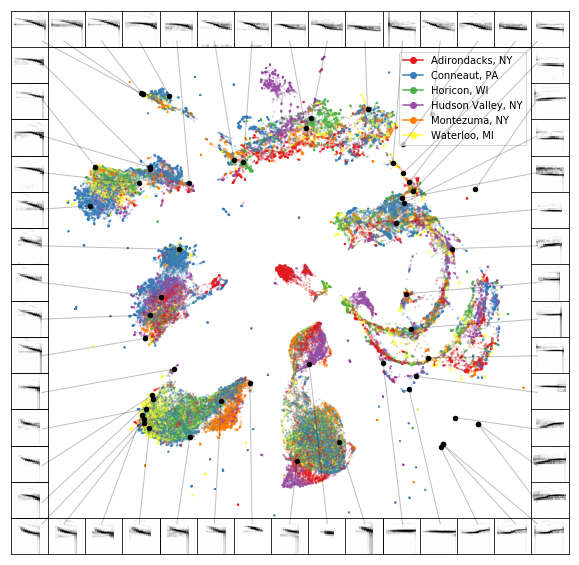

In [41]:
scatter_spec(
    np.vstack(z),
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': list(population),
        'alpha':0.25,
        's': 1,
        'show_legend': True,
        'color_palette':'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#
save_fig(FIGURE_DIR / 'swamp_sparrow_population', dpi=300, save_jpg=True)
plt.show()

In [39]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

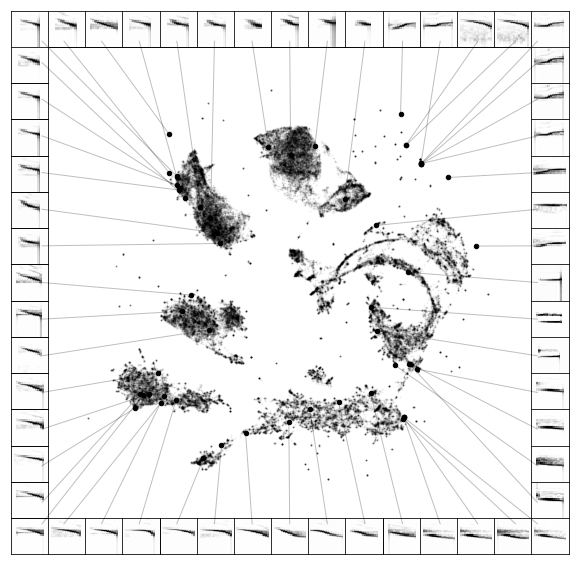

In [40]:
scatter_spec(
    np.vstack(z),
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        #'labels': subset_df.syllable.values,
        'alpha':0.05,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
save_fig(FIGURE_DIR / 'swamp_sparrow', dpi=300, save_jpg=True)
plt.show()

### draw transitions by population